## DEMO MLP

In [1]:
import sys
sys.path.append('../../TINY/')
import TINY 
import UTILS
from mes_imports import *
import load_data_Loader
import SOLVE_EB as EB

In [2]:
torch.set_default_dtype(torch.float64)

We define the name of the layer by 
- 'L' for a linear layer
- 'CB' for a convolutional followed by a batchnorm


In [3]:
layer_name = {1 : 'L', 2 : 'L', 3 :'L'}

We define the starting size of the model by the number of neurons in the starting architecture. In this example we start with 5 neurons by hidden layers.
The last layer should be of the size of the prediction. For the MNIST dataset there is 10 classes so the size of the last layer is 10.

In [4]:
skeleton = {0: {}, 1 : {'size' : 5}, 2 : {'size' : 5}, 3 : {'size' : 10}}

We select the activation function for all layers. In this notebook as we use the CrossEntropy loss https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html we choose the Identity for the activation function at the last layer.

In [5]:
fct = {depth : torch.nn.ReLU() for depth in range(1, 3)}
fct.update({3 : torch.nn.Identity()})

We define the loss function :

In [6]:
### Loss function ###
def Loss_entropy(x1, x2, reduction = 'mean') :
    #print(x1.shape, x2.shape)
    return(torch.nn.CrossEntropyLoss(reduction = reduction)(x1, x2))


## MLP

In [7]:
dico_parameters = {
                 'skeleton' : copy.deepcopy(skeleton),
                'Loss' : Loss_entropy,
                'fct' : fct,
                'layer_name' :layer_name,
                'init_deplacement' : 1e-8, # min amplitude factor
                'batch_size' : 64,# batchsize for training
                'lr' : 1e-2,# leraning rate for training
                'lambda_method' : 0, # = 0 for searching the amplitude factor, if > 0 the 
                                     # amplitude factor is automatically set to this value
                'accroissement_decay' : 1e-4,# the minimum decay to update the 
                                             # architecture with the NewNeurons/BestUpdate 
                'depth_seuil' : {1 : 10, 2 : 10},# maximum number of neurons to add per layer
                'lu_lin' : 2,
                'max_batch_estimation' : 100,
                'gradient_clip' : 1e-3,
                'max_amplitude' : 1., # max amplitude factor
                'ind_lmbda_shape' : 1000,
                'init_X_shape' : [1, 28, 28], # size of the input, if your X are 1-d, unsqueeze them
                'len_train_dataset' : 50000, # size of training data
                'len_test_dataset' : 10000, # size of testing data
                'selection_neuron' : UTILS.selection_neuron_seuil,
                'how_to_define_batchsize' : UTILS.indices_non_constant,
                }


In [8]:
MLP_model = TINY.TINY(dico_parameters)
MLP_model.training_data, MLP_model.test_data = load_data_Loader.load_database_MNIST(batch_size = MLP_model.max_batch_estimation)
MLP_model.tr_loader, MLP_model.te_loader =  iter(UTILS.cycle(DataLoader(MLP_model.training_data, batch_size=MLP_model.batch_size, shuffle=True))),  iter(UTILS.cycle(DataLoader(MLP_model.test_data, batch_size=MLP_model.batch_size, shuffle=True)))

After layer 1 : x.shape=torch.Size([1, 5])
After layer 2 : x.shape=torch.Size([1, 5])
After layer 3 : x.shape=torch.Size([1, 10])
Time to build the model: 0.04 seconds


TypeError: load_database_MNIST() got an unexpected keyword argument 'batch_size'

In [ ]:
getattr

In [ ]:
MLP_model.tr_loader


The starting performances are :

In [ ]:
X, Y = MLP_model.get_batch(data = 'tr', device = my_device_0) # parametres par défault
X_te, Y_te =  MLP_model.get_batch(data = 'te', device = my_device_0)

In [ ]:
with torch.no_grad() :
    print('Loss on train :', MLP_model.Loss(Y, MLP_model(X)).item(), ' || Loss on test :', MLP_model.Loss(Y_te, MLP_model(X_te)).item())
    print('Accuracy on train :', UTILS.calculate_accuracy(Y, MLP_model(X)), ' || Accuracy on test :', UTILS.calculate_accuracy(Y_te, MLP_model(X_te)))

You can acces the basic functions of your model in the module TINY
- count_parameters, count_parameters_layer, get_parameters, ....
- get_batch, train_batch, ...

In [ ]:
optimizer = torch.optim.SGD(MLP_model.parameters(), lr = 1e-4)
L_tr, L_te, _, A_tr, A_te, _, T = MLP_model.train_batch(optimizer = optimizer, nbr_epoch = 0.01)

In [ ]:
plt.plot(L_tr, label = 'L_tr')
plt.plot(L_te, label = 'L_te')
plt.xlabel('step')
plt.ylabel('Accuracy test')
plt.legend()
plt.show()

## architecture growth and training

In [49]:
df_tracker = pd.DataFrame()
A_tr, A_te, L_tr, L_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([0])
to_add = [1, 2] ##  depth where neurons can be added
nbr_pass = 20
#nbr_epochs_betw_adding = 0.5 ## Epochs of training between adding
nbr_steps_betw_adding = 100

name_file_expe = 'results/' 

In [50]:
def update_quantity_of_interest() :
    global L_tr, L_te, A_tr, A_te, T, df_tracker
    dico_tracker = {'vps' + str(i) : [ MLP_model.valeurs_propres[i].item()] for i in range(len(MLP_model.valeurs_propres))}
    
    dico_tracker.update({'depth_add' : best_depth, 'nbr_added_neuron': MLP_model.nbr_added_neuron})
    dico_tracker.update({'accroissement' : [dico_EB[best_depth]['accroissement']], 'portion_gain' : [dico_EB[best_depth]['portion_gain']],
                        'nbr_parameters_apres' : [MLP_model.count_parameters()], 'nbr_parameters_avant' : [nbr_parameters_avant],
                        'T' : [T[-1]], 'len_L_tr' : [len(L_tr)], 'lu_conv' : [MLP_model.lu_conv]})
    
    df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict(dico_tracker)], ignore_index=True)
    
    L_tr = np.concatenate([L_tr, l_tr])
    L_te = np.concatenate([L_te, l_te])
    A_tr = np.concatenate([A_tr, a_tr])
    A_te = np.concatenate([A_te, a_te])
    T = np.concatenate([T, t +  T[-1]])

    
    
def AugBatchSizeLearning() :
    MLP_model.batch_size = math.ceil(np.sqrt(MLP_model.count_parameters() / nbr_parameters_avant) *  MLP_model.batch_size)
    #MLP_model.batch_size = math.ceil(MLP_model.count_parameters() / nbr_parameters_avant *  MLP_model.batch_size)

In [51]:
#MLP_model.tr_loader

In [31]:
count = 1

In [57]:
for j in tqdm(range(5)) :
    for k in range(len(to_add)) :
        ## search for the best depth to add the new neurons ##
        nbr_parameters_avant = MLP_model.count_parameters()
        gc.collect()
        torch.cuda.empty_cache()
        depth_ajout = to_add
        depth_in_decreasing_criterion, dico_EB = EB.where_is_EB_best_solved(MLP_model, depths = depth_ajout)

        best_depth = depth_in_decreasing_criterion[0]
        dico_EB_bd = dico_EB[best_depth]
        alpha, omega, bias_alpha, vps = dico_EB_bd['alpha'], dico_EB_bd['omega'], dico_EB_bd['bias_alpha'], dico_EB_bd['vps']
        lambda_method = dico_EB_bd['beta_min']

        MLP_model.alpha, MLP_model.omega, MLP_model.bias_alpha, MLP_model.valeurs_propres = None, None, None, []
        MLP_model.TAB_Add = None

        
        if lambda_method > 0 :
            MLP_model.dico_w, MLP_model.lambda_method = dico_EB_bd['dico_w'], dico_EB_bd['beta_min']
            EB.add_neurons(MLP_model, best_depth, alpha = alpha, omega = omega, bias_alpha = bias_alpha, valeurs_propres = vps)
            MLP_model.lambda_method = torch.tensor(0., device = my_device_0)
        #########################################################
        
        
        ## Training Loops ##
        AugBatchSizeLearning()
        MLP_model.tr_loader, MLP_model.te_loader =  iter(UTILS.cycle(DataLoader(MLP_model.training_data, batch_size=MLP_model.batch_size, shuffle=True))),  iter(UTILS.cycle(DataLoader(MLP_model.test_data, batch_size=MLP_model.batch_size, shuffle=True)))
        optimizer = torch.optim.SGD(MLP_model.parameters(), lr = MLP_model.lr)
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.0001, total_iters=25)
        MLP_model.scheduler = scheduler
        l_tr, l_te, l_va, a_tr, a_te, a_va, t = MLP_model.train_batch(nbr_step = nbr_steps_betw_adding, optimizer = optimizer)
        #####################
        update_quantity_of_interest()
    
    
    df_performance = pd.DataFrame.from_dict({'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T[1:], 
                                             'BatchSize' : np.ones(A_te.shape) * MLP_model.batch_size})
    df_tracker.to_csv(name_file_expe + '/df_tracker.csv')
    df_performance.to_csv(name_file_expe + '/df_performance.csv')
    MLP_model.T = T[-1]
    MLP_model.len_L_tr = len(L_tr)
    del MLP_model.tr_loader, MLP_model.te_loader
    UTILS.save_model_to_file(MLP_model, path = name_file_expe + '/' , name='model_' + str((j + 1) * (k + 1)))





  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 50000


*** started  Add at  1 ***
Batch size for estimation : 50000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 75.7818505568624
norm_x_over_norm_DE_depthp1 :  5412.57259428076
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -2.174182721081941e-07, -4.3481016526181193e-07]  ... [-0.0005875432605257358, -0.0006385258979269559, 0.0004072505028638318]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [3.0517578125e-05, 6.103515625e-05, 0.0001220703125]
rate of decrease : 0.0019248807879457025 ampli_fct : 6.103515625e-05 L[0] : 0.3317223081687112


*** started  NG at  3 ***
Batch size for estimation : 4900


*** started  Add at  2 ***
Batch size for estimation : 3000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| 



*** started  Add at  2 ***
Batch size for estimation : 3000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 120.90871915871917
norm_x_over_norm_DE_depthp1 :  123.36412549866802
L_plus < L_moins: 0.2744414784366176 < 0.2744416123406916
Delta Loss :  [0.0, -7.709821797652339e-08, -1.5419369009395112e-07]  ... [-0.0008842493023628051, -0.0009695590419955269, 0.001645103618920507]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0001220703125, 0.000244140625, 0.00048828125]
rate of decrease : 0.002950543478472863 ampli_fct : 0.000244140625 L[0] : 0.3286035434046034


*** started  Add at  2 ***
Batch size for estimation : 3000
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.970628507818449
norm_x_over_norm_DE_depthp1 :  0.008138627567966895
amplitude factor for the new neurons : 0.0002441



*** started  NG at  2 ***
Batch size for estimation : 50000


*** started  Add at  1 ***
Batch size for estimation : 50000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 75.7848199324092
norm_x_over_norm_DE_depthp1 :  5729.811428047741
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -6.874472019413602e-08, -1.3745819588129038e-07]  ... [-5.157369167729797e-05, -6.322513652740058e-05, -2.132340422594803e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05]
rate of decrease : 0.00024539565875702726 ampli_fct : 1.52587890625e-05 L[0] : 0.2576457010187025


*** started  NG at  3 ***
Batch size for estimation : 6100


*** started  Add at  2 ***
Batch size for estimation : 3600
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional 

In [23]:
#UTILS.save_model_to_file(MLP_model, path = name_file_expe + '/' , name='model_' + str((j + 1) * (k + 1)))


### Plotting

In [53]:
path = 'results/'

In [54]:
### Loss function ###
#def Loss_entropy(x1, x2, reduction = 'mean') :
#    #print(x1.shape, x2.shape)
#    return(torch.nn.CrossEntropyLoss(reduction = reduction)(x1, x2))
#####################

#df_tracker = pd.read_csv(path + 'df_tracker.csv')
#df_performance = pd.read_csv(path + 'df_performance.csv')
#MLP_model = UTILS.read_model_from_file(path = 'resultats/', name = 'model_20')

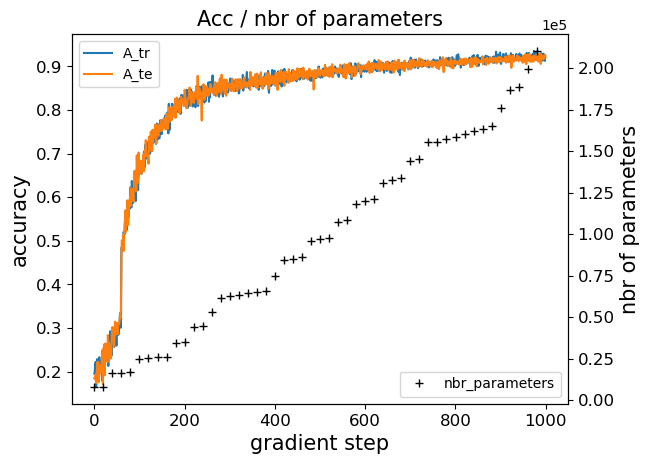

In [58]:
fig, ax = plt.subplots(1, 1)
coef = 5
ax.plot(UTILS.lisser_courbe(df_performance[['A_tr', 'A_te']], coef = coef), label = ['A_tr', 'A_te'])
ax.legend()
ax_nbrp = ax.twinx()
ax_nbrp.plot(df_tracker['len_L_tr'] / coef, df_tracker['nbr_parameters_apres'], '+', label = 'nbr_parameters', color = 'black')
ax_nbrp.legend(loc = 'lower right')
ax.set_title('Acc / nbr of parameters', fontsize = 15)
ax.set_ylabel('accuracy', fontsize = 15)
ax.set_xlabel('gradient step', fontsize = 15)

ax_nbrp.set_ylabel('nbr of parameters', fontsize = 15)

ax_nbrp.tick_params(axis='both', which='major', labelsize=12)
ax_nbrp.tick_params(axis='both', which='minor', labelsize=10)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.show()

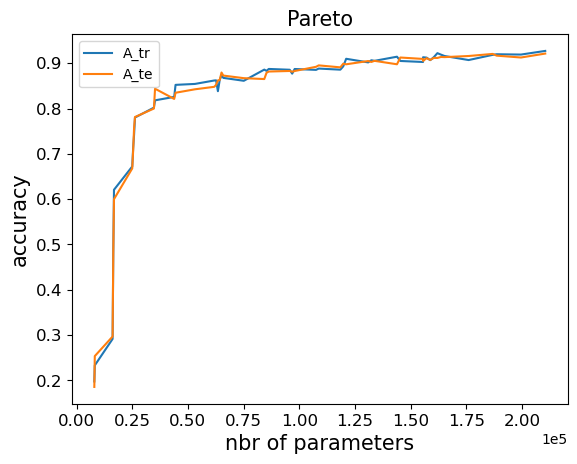

In [59]:
coef = 10
plt.plot(df_tracker['nbr_parameters_apres'], UTILS.lisser_courbe(df_performance['A_tr'].values, coef = coef)[(df_tracker['len_L_tr'].values /coef).astype(int)], label = 'A_tr')
plt.plot(df_tracker['nbr_parameters_apres'], UTILS.lisser_courbe(df_performance['A_te'].values, coef = coef)[(df_tracker['len_L_tr'].values /coef).astype(int)], label = 'A_te')


plt.xlabel('nbr of parameters', fontsize = 15)
plt.ylabel('accuracy', fontsize = 15)
plt.title('Pareto', fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend()
plt.show()

In [60]:
df_performance[['A_tr', 'A_te']][-20:].mean(axis = 0)

A_tr    0.920996
A_te    0.922886
dtype: float64

In [61]:
MLP_model.skeleton

{0: {'size': 784}, 1: {'size': 190}, 2: {'size': 305}, 3: {'size': 10}}